# 第43章: 潜在拡散モデル（Latent Diffusion Models）

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 潜在拡散モデル（LDM）の仕組みを理解できる
- [ ] VAEによる画像の圧縮・復元を実装できる
- [ ] 潜在空間での拡散を理解できる
- [ ] Stable Diffusionの基本構造を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 36（VAE）
- ✅ Notebook 37-42（拡散モデル基礎）

⏱️ **推定学習時間**: 150-180分  
📊 **難易度**: ★★★★★（上級）  
🎓 **カテゴリ**: 理論 + 実践

---

## 🌟 はじめに

これまでの拡散モデルは**ピクセル空間**で動作していました。高解像度画像では計算コストが膨大になります。

### 🤔 ピクセル空間拡散の課題

| 解像度 | ピクセル数 | 計算コスト |
|--------|-----------|------------|
| 28×28 (MNIST) | 784 | 低 |
| 256×256 | 65,536 | 中 |
| 512×512 | 262,144 | 高 |
| 1024×1024 | 1,048,576 | 非常に高 |

### 💡 潜在拡散モデル（LDM）の解決策

**アイデア**: 画像を低次元の潜在空間に圧縮してから拡散を行う

```
[ピクセル空間拡散]
画像 (512×512×3) → 拡散 → 生成画像

[潜在空間拡散]
画像 (512×512×3) → VAEエンコーダ → 潜在 (64×64×4) → 拡散 → VAEデコーダ → 生成画像
```

### 📊 LDMの構成要素

1. **VAE（Variational Autoencoder）**: 画像 ↔ 潜在空間の変換
2. **U-Net**: 潜在空間での拡散
3. **条件付けモジュール**: テキストなどの条件を注入

In [1]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
Device: mps
✅ ライブラリのインポート完了


---

## 1. LDMのアーキテクチャ概要

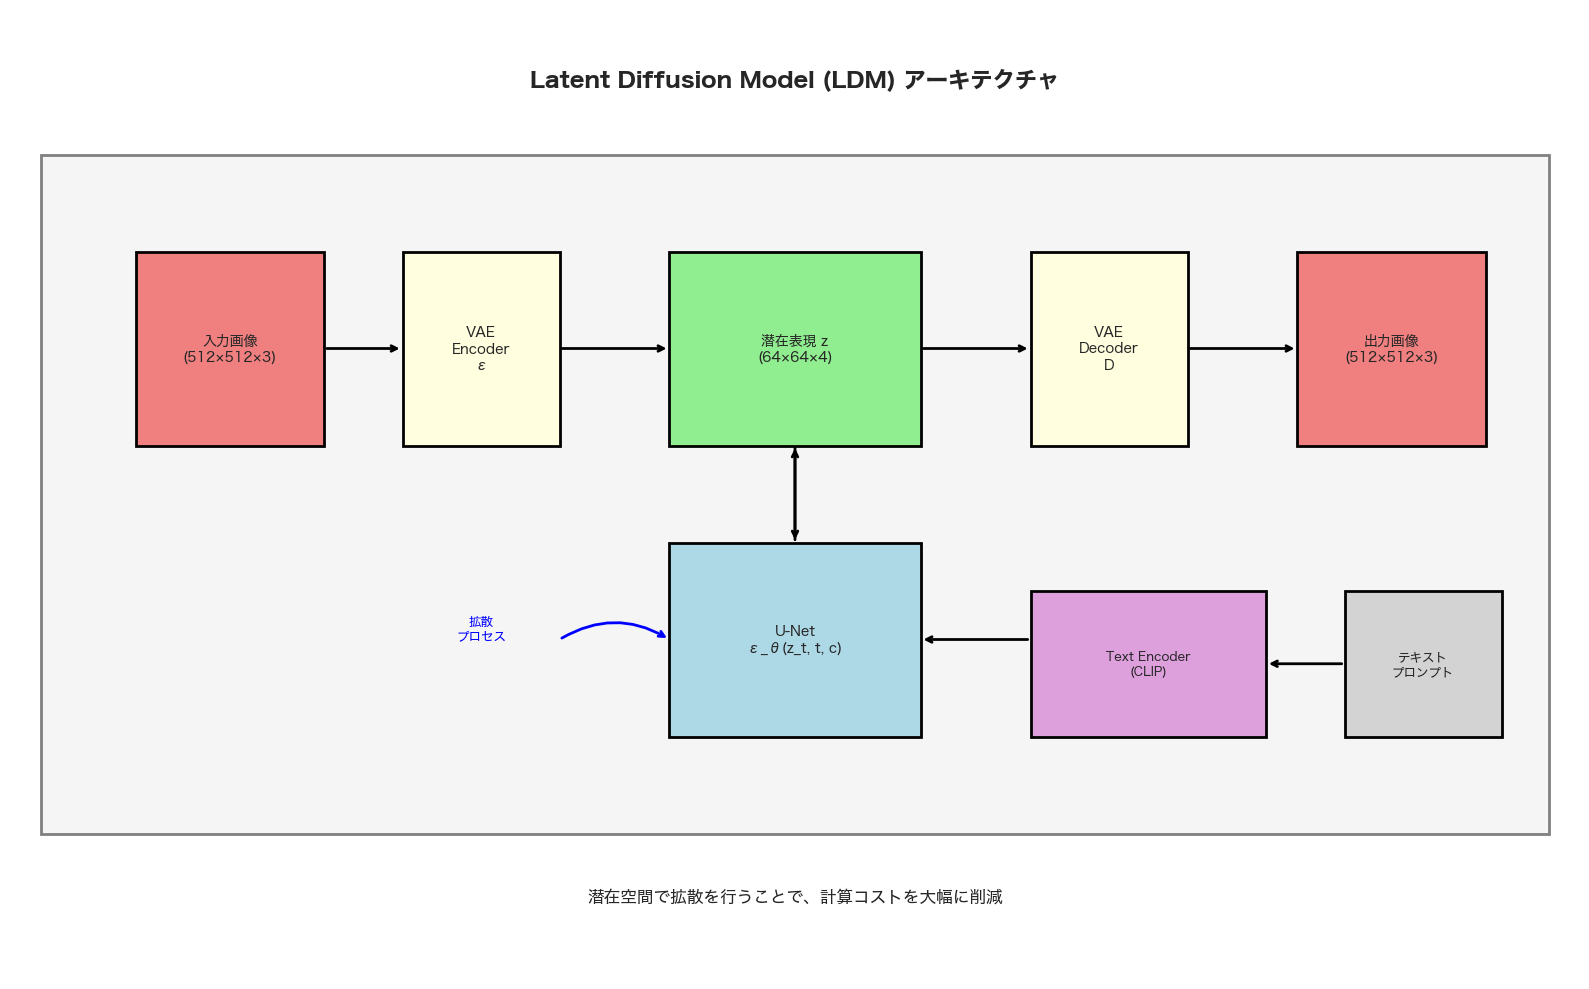

In [2]:
# ============================================================
# LDMのアーキテクチャ図
# ============================================================

fig, ax = plt.subplots(figsize=(16, 10))

# 背景
ax.add_patch(plt.Rectangle((0.02, 0.15), 0.96, 0.7, 
                           facecolor='whitesmoke', edgecolor='gray', lw=2))

# タイトル
ax.text(0.5, 0.92, 'Latent Diffusion Model (LDM) アーキテクチャ', 
        fontsize=16, fontweight='bold', ha='center')

# コンポーネント
components = [
    # (x, y, width, height, label, color)
    (0.08, 0.55, 0.12, 0.2, '入力画像\n(512×512×3)', 'lightcoral'),
    (0.25, 0.55, 0.1, 0.2, 'VAE\nEncoder\nε', 'lightyellow'),
    (0.42, 0.55, 0.16, 0.2, '潜在表現 z\n(64×64×4)', 'lightgreen'),
    (0.42, 0.25, 0.16, 0.2, 'U-Net\nε_θ(z_t, t, c)', 'lightblue'),
    (0.65, 0.55, 0.1, 0.2, 'VAE\nDecoder\nD', 'lightyellow'),
    (0.82, 0.55, 0.12, 0.2, '出力画像\n(512×512×3)', 'lightcoral'),
]

for x, y, w, h, label, color in components:
    ax.add_patch(plt.Rectangle((x, y), w, h, 
                               facecolor=color, edgecolor='black', lw=2))
    ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=10)

# 条件付けモジュール
ax.add_patch(plt.Rectangle((0.65, 0.25), 0.15, 0.15,
                           facecolor='plum', edgecolor='black', lw=2))
ax.text(0.725, 0.325, 'Text Encoder\n(CLIP)', ha='center', va='center', fontsize=9)

ax.add_patch(plt.Rectangle((0.85, 0.25), 0.1, 0.15,
                           facecolor='lightgray', edgecolor='black', lw=2))
ax.text(0.9, 0.325, 'テキスト\nプロンプト', ha='center', va='center', fontsize=9)

# 矢印
arrows = [
    ((0.20, 0.65), (0.25, 0.65)),  # 入力 → エンコーダ
    ((0.35, 0.65), (0.42, 0.65)),  # エンコーダ → 潜在
    ((0.50, 0.55), (0.50, 0.45)),  # 潜在 → U-Net
    ((0.50, 0.45), (0.50, 0.55)),  # U-Net → 潜在（ループ）
    ((0.58, 0.65), (0.65, 0.65)),  # 潜在 → デコーダ
    ((0.75, 0.65), (0.82, 0.65)),  # デコーダ → 出力
    ((0.85, 0.325), (0.80, 0.325)),  # テキスト → CLIP
    ((0.65, 0.35), (0.58, 0.35)),  # CLIP → U-Net
]

for (x1, y1), (x2, y2) in arrows:
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# 拡散プロセスの矢印（ループ）
ax.annotate('', xy=(0.42, 0.35), xytext=(0.35, 0.35),
            arrowprops=dict(arrowstyle='->', lw=2, color='blue',
                           connectionstyle='arc3,rad=-0.3'))
ax.text(0.30, 0.35, '拡散\nプロセス', fontsize=9, ha='center', color='blue')

# ラベル
ax.text(0.5, 0.08, '潜在空間で拡散を行うことで、計算コストを大幅に削減', 
        fontsize=12, ha='center', style='italic')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

---

## 2. VAEコンポーネント

LDMの核心は、画像を効率的に圧縮・復元できるVAEです。

In [3]:
# ============================================================
# シンプルなVAE（LDM用）
# ============================================================

class ResidualBlock(nn.Module):
    """残差ブロック"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.activation = nn.SiLU()
        
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        h = self.activation(self.norm1(self.conv1(x)))
        h = self.norm2(self.conv2(h))
        return self.activation(h + self.skip(x))


class VAEEncoder(nn.Module):
    """VAEエンコーダ: 画像 → 潜在表現"""
    
    def __init__(self, in_channels=1, latent_channels=4, base_channels=32):
        super().__init__()
        
        self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        
        # ダウンサンプリング
        self.down1 = nn.Sequential(
            ResidualBlock(base_channels, base_channels * 2),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, stride=2, padding=1),
        )
        self.down2 = nn.Sequential(
            ResidualBlock(base_channels * 2, base_channels * 4),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, stride=2, padding=1),
        )
        
        # 中間
        self.mid = ResidualBlock(base_channels * 4, base_channels * 4)
        
        # 出力（平均と分散）
        self.out = nn.Conv2d(base_channels * 4, latent_channels * 2, 3, padding=1)
    
    def forward(self, x):
        h = self.init_conv(x)
        h = self.down1(h)
        h = self.down2(h)
        h = self.mid(h)
        h = self.out(h)
        
        # 平均と対数分散に分割
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar


class VAEDecoder(nn.Module):
    """VAEデコーダ: 潜在表現 → 画像"""
    
    def __init__(self, out_channels=1, latent_channels=4, base_channels=32):
        super().__init__()
        
        self.init_conv = nn.Conv2d(latent_channels, base_channels * 4, 3, padding=1)
        
        # 中間
        self.mid = ResidualBlock(base_channels * 4, base_channels * 4)
        
        # アップサンプリング
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels * 4, base_channels * 2, 3, padding=1),
            ResidualBlock(base_channels * 2, base_channels * 2),
        )
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(base_channels * 2, base_channels, 3, padding=1),
            ResidualBlock(base_channels, base_channels),
        )
        
        # 出力
        self.out = nn.Conv2d(base_channels, out_channels, 3, padding=1)
    
    def forward(self, z):
        h = self.init_conv(z)
        h = self.mid(h)
        h = self.up1(h)
        h = self.up2(h)
        return self.out(h)


class VAE(nn.Module):
    """VAE: エンコーダ + デコーダ"""
    
    def __init__(self, in_channels=1, latent_channels=4, base_channels=32):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_channels, base_channels)
        self.decoder = VAEDecoder(in_channels, latent_channels, base_channels)
        self.latent_channels = latent_channels
    
    def encode(self, x):
        """画像を潜在空間にエンコード"""
        mean, logvar = self.encoder(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        """再パラメータ化トリック"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        """潜在表現を画像にデコード"""
        return self.decoder(z)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        recon = self.decode(z)
        return recon, mean, logvar

# テスト
vae = VAE(in_channels=1, latent_channels=4, base_channels=32).to(device)
x = torch.randn(2, 1, 28, 28, device=device)
recon, mean, logvar = vae(x)

print(f"入力: {x.shape}")
print(f"潜在表現: {mean.shape}")
print(f"復元: {recon.shape}")
print(f"\n圧縮率: {x.numel() / mean.numel():.1f}x")
print(f"パラメータ数: {sum(p.numel() for p in vae.parameters()):,}")

入力: torch.Size([2, 1, 28, 28])
潜在表現: torch.Size([2, 4, 7, 7])
復元: torch.Size([2, 1, 28, 28])

圧縮率: 4.0x
パラメータ数: 1,263,497


---

## 3. 潜在空間でのU-Net

In [4]:
# ============================================================
# 潜在空間用U-Net
# ============================================================

class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class TimeConditionedBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.emb_proj = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, out_ch))
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    
    def forward(self, x, emb):
        h = self.act(self.norm1(self.conv1(x)))
        h = h + self.emb_proj(emb)[:, :, None, None]
        h = self.act(self.norm2(self.conv2(h)))
        return h + self.skip(x)


class LatentUNet(nn.Module):
    """潜在空間用のU-Net（任意のサイズに対応）"""
    
    def __init__(self, latent_channels=4, time_dim=128, base_ch=64):
        super().__init__()
        
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )
        
        self.init_conv = nn.Conv2d(latent_channels, base_ch, 3, padding=1)
        
        # エンコーダ
        self.down1 = TimeConditionedBlock(base_ch, base_ch * 2, time_dim)
        self.down2 = TimeConditionedBlock(base_ch * 2, base_ch * 4, time_dim)
        self.pool1 = nn.Conv2d(base_ch * 2, base_ch * 2, 3, stride=2, padding=1)
        
        # ボトルネック
        self.mid = TimeConditionedBlock(base_ch * 4, base_ch * 4, time_dim)
        
        # デコーダ
        self.up_conv1 = TimeConditionedBlock(base_ch * 4 + base_ch * 2, base_ch * 2, time_dim)
        self.up_conv2 = TimeConditionedBlock(base_ch * 2 + base_ch, base_ch, time_dim)
        
        self.final = nn.Conv2d(base_ch, latent_channels, 3, padding=1)
    
    def forward(self, z, t):
        t_emb = self.time_embed(t.float())
        
        h = self.init_conv(z)
        s1 = h  # skip (H, W)
        
        h = self.down1(h, t_emb)
        s2 = h  # skip (H, W)
        h = self.pool1(h)  # (H//2, W//2)
        
        h = self.down2(h, t_emb)
        h = self.mid(h, t_emb)
        
        # アップサンプリング: s2のサイズに合わせる
        h = F.interpolate(h, size=s2.shape[2:], mode='nearest')
        h = torch.cat([h, s2], dim=1)
        h = self.up_conv1(h, t_emb)
        
        # s1のサイズに合わせる（必要な場合）
        if h.shape[2:] != s1.shape[2:]:
            h = F.interpolate(h, size=s1.shape[2:], mode='nearest')
        h = torch.cat([h, s1], dim=1)
        h = self.up_conv2(h, t_emb)
        
        return self.final(h)

# テスト
latent_unet = LatentUNet(latent_channels=4).to(device)
z = torch.randn(2, 4, 7, 7, device=device)  # 28/4 = 7
t = torch.randint(0, 1000, (2,), device=device)
out = latent_unet(z, t)

print(f"潜在入力: {z.shape}")
print(f"潜在出力: {out.shape}")
print(f"パラメータ数: {sum(p.numel() for p in latent_unet.parameters()):,}")

潜在入力: torch.Size([2, 4, 7, 7])
潜在出力: torch.Size([2, 4, 7, 7])
パラメータ数: 3,522,116


---

## 4. Latent Diffusion Model クラス

In [5]:
# ============================================================
# Latent Diffusion Model
# ============================================================

class LatentDiffusion:
    """潜在拡散モデル"""
    
    def __init__(self, vae, unet, T=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.vae = vae
        self.unet = unet
        self.T = T
        self.device = device
        
        # ノイズスケジュール
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
        self.alpha_bars_prev = F.pad(self.alpha_bars[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.betas * (1 - self.alpha_bars_prev) / (1 - self.alpha_bars)
    
    @torch.no_grad()
    def encode(self, x):
        """画像を潜在空間にエンコード"""
        mean, logvar = self.vae.encode(x)
        z = self.vae.reparameterize(mean, logvar)
        return z
    
    @torch.no_grad()
    def decode(self, z):
        """潜在表現を画像にデコード"""
        return self.vae.decode(z)
    
    def q_sample(self, z_0, t, noise=None):
        """潜在空間での前方拡散"""
        if noise is None:
            noise = torch.randn_like(z_0)
        alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        z_t = torch.sqrt(alpha_bar_t) * z_0 + torch.sqrt(1 - alpha_bar_t) * noise
        return z_t, noise
    
    def compute_loss(self, x):
        """訓練損失を計算"""
        batch_size = x.shape[0]
        
        # 画像を潜在空間にエンコード
        with torch.no_grad():
            z_0 = self.encode(x)
        
        # ランダムなタイムステップ
        t = torch.randint(0, self.T, (batch_size,), device=self.device)
        
        # 潜在空間で前方拡散
        z_t, noise = self.q_sample(z_0, t)
        
        # ノイズを予測
        noise_pred = self.unet(z_t, t)
        
        return F.mse_loss(noise_pred, noise)
    
    @torch.no_grad()
    def p_sample(self, z_t, t):
        """1ステップの逆方向サンプリング（潜在空間）"""
        batch_size = z_t.shape[0]
        t_tensor = torch.full((batch_size,), t, device=self.device, dtype=torch.long)
        
        noise_pred = self.unet(z_t, t_tensor)
        
        alpha_t = self.alphas[t]
        alpha_bar_t = self.alpha_bars[t]
        beta_t = self.betas[t]
        
        mean = (1 / torch.sqrt(alpha_t)) * (
            z_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred
        )
        
        if t > 0:
            noise = torch.randn_like(z_t)
            sigma_t = torch.sqrt(self.posterior_variance[t])
            z_prev = mean + sigma_t * noise
        else:
            z_prev = mean
        
        return z_prev
    
    @torch.no_grad()
    def sample(self, num_samples, latent_shape):
        """サンプリング"""
        # 潜在空間でノイズから開始
        z = torch.randn(num_samples, *latent_shape, device=self.device)
        
        for t in tqdm(reversed(range(self.T)), total=self.T, desc='Sampling'):
            z = self.p_sample(z, t)
        
        # 潜在表現を画像にデコード
        x = self.decode(z)
        
        return x, z

print("✅ LatentDiffusionクラスを定義しました")

✅ LatentDiffusionクラスを定義しました


---

## 5. VAEの事前訓練

In [6]:
# ============================================================
# データセット
# ============================================================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

subset_size = 10000
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_subset = Subset(train_dataset, indices)

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"データセットサイズ: {len(train_subset):,}")

データセットサイズ: 10,000


In [7]:
# ============================================================
# VAEの訓練
# ============================================================

def vae_loss(recon, x, mean, logvar, kl_weight=0.001):
    """VAE損失 = 再構成損失 + KLダイバージェンス"""
    recon_loss = F.mse_loss(recon, x, reduction='sum') / x.shape[0]
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.shape[0]
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

# VAE
vae = VAE(in_channels=1, latent_channels=4, base_channels=32).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# 訓練
vae_epochs = 15
vae_losses = []

print("VAE訓練開始...")
for epoch in range(vae_epochs):
    vae.train()
    epoch_losses = []
    
    for batch, _ in train_loader:
        batch = batch.to(device)
        
        recon, mean, logvar = vae(batch)
        loss, recon_loss, kl_loss = vae_loss(recon, batch, mean, logvar)
        
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    vae_losses.extend(epoch_losses)
    print(f"  Epoch {epoch+1}/{vae_epochs}: Loss = {avg_loss:.4f}")

print("✅ VAE訓練完了")

VAE訓練開始...
  Epoch 1/15: Loss = 194.7483
  Epoch 2/15: Loss = 36.8584
  Epoch 3/15: Loss = 20.5389
  Epoch 4/15: Loss = 14.8921
  Epoch 5/15: Loss = 10.9967
  Epoch 6/15: Loss = 9.5626
  Epoch 7/15: Loss = 8.1220
  Epoch 8/15: Loss = 7.7024
  Epoch 9/15: Loss = 6.6173
  Epoch 10/15: Loss = 6.1592
  Epoch 11/15: Loss = 5.7413
  Epoch 12/15: Loss = 5.4595
  Epoch 13/15: Loss = 5.5286
  Epoch 14/15: Loss = 4.7873
  Epoch 15/15: Loss = 5.0514
✅ VAE訓練完了


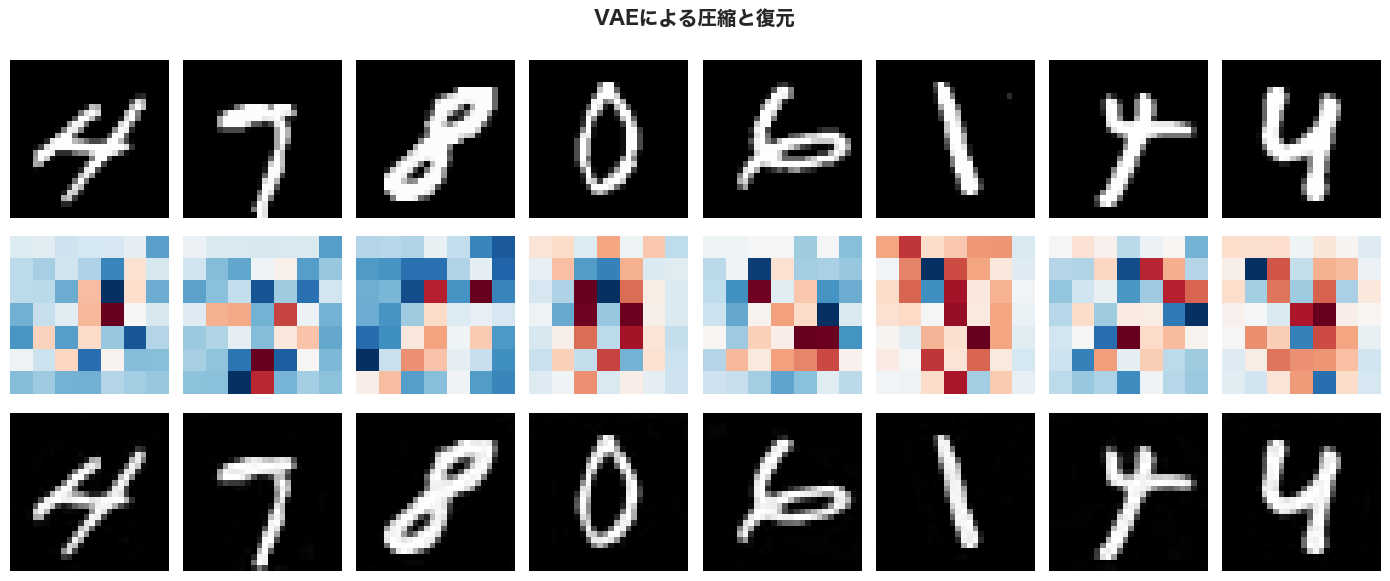

元画像サイズ: torch.Size([8, 1, 28, 28])
潜在表現サイズ: torch.Size([8, 4, 7, 7])
圧縮率: 4.0x


In [8]:
# ============================================================
# VAEの復元結果を確認
# ============================================================

vae.eval()

# サンプル画像を取得
sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch[:8].to(device)

with torch.no_grad():
    recon, mean, logvar = vae(sample_batch)

fig, axes = plt.subplots(3, 8, figsize=(14, 6))

for i in range(8):
    # 元画像
    img = sample_batch[i].squeeze().cpu().numpy() * 0.5 + 0.5
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('元画像', fontsize=11)
    
    # 潜在表現（最初の2チャンネル）
    latent = mean[i, :2].mean(dim=0).cpu().numpy()
    axes[1, i].imshow(latent, cmap='RdBu_r')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('潜在表現', fontsize=11)
    
    # 復元画像
    recon_img = recon[i].squeeze().cpu().numpy() * 0.5 + 0.5
    recon_img = np.clip(recon_img, 0, 1)
    axes[2, i].imshow(recon_img, cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('復元', fontsize=11)

plt.suptitle('VAEによる圧縮と復元', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"元画像サイズ: {sample_batch.shape}")
print(f"潜在表現サイズ: {mean.shape}")
print(f"圧縮率: {sample_batch.numel() / mean.numel():.1f}x")

---

## 6. 潜在拡散モデルの訓練

In [9]:
# ============================================================
# LDMの訓練
# ============================================================

# VAEを固定
vae.eval()
for param in vae.parameters():
    param.requires_grad = False

# 潜在空間のサイズを確認
with torch.no_grad():
    sample = torch.randn(1, 1, 28, 28, device=device)
    z_sample = vae.reparameterize(*vae.encode(sample))
    latent_shape = z_sample.shape[1:]  # (4, 7, 7)
    print(f"潜在空間のサイズ: {latent_shape}")

# U-Net
latent_unet = LatentUNet(latent_channels=4, time_dim=128, base_ch=64).to(device)

# LDM
ldm = LatentDiffusion(vae, latent_unet, T=1000, device=device)

# オプティマイザ
unet_optimizer = torch.optim.Adam(latent_unet.parameters(), lr=2e-4)

# 訓練
ldm_epochs = 20
ldm_losses = []

print("\nLDM訓練開始...")
for epoch in range(ldm_epochs):
    latent_unet.train()
    epoch_losses = []
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{ldm_epochs}')
    for batch, _ in pbar:
        batch = batch.to(device)
        
        loss = ldm.compute_loss(batch)
        
        unet_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(latent_unet.parameters(), 1.0)
        unet_optimizer.step()
        
        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = np.mean(epoch_losses)
    ldm_losses.extend(epoch_losses)
    print(f"  Epoch {epoch+1}: Loss = {avg_loss:.4f}")

print("✅ LDM訓練完了")

潜在空間のサイズ: torch.Size([4, 7, 7])

LDM訓練開始...


Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 1: Loss = 0.4054


Epoch 2/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 2: Loss = 0.2028


Epoch 3/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 3: Loss = 0.1848


Epoch 4/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 4: Loss = 0.1746


Epoch 5/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 5: Loss = 0.1637


Epoch 6/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 6: Loss = 0.1582


Epoch 7/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 7: Loss = 0.1576


Epoch 8/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 8: Loss = 0.1532


Epoch 9/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 9: Loss = 0.1514


Epoch 10/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 10: Loss = 0.1473


Epoch 11/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 11: Loss = 0.1459


Epoch 12/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 12: Loss = 0.1436


Epoch 13/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 13: Loss = 0.1438


Epoch 14/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 14: Loss = 0.1386


Epoch 15/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 15: Loss = 0.1379


Epoch 16/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 16: Loss = 0.1393


Epoch 17/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 17: Loss = 0.1363


Epoch 18/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 18: Loss = 0.1365


Epoch 19/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 19: Loss = 0.1346


Epoch 20/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 20: Loss = 0.1344
✅ LDM訓練完了


---

## 7. サンプリング

サンプル生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

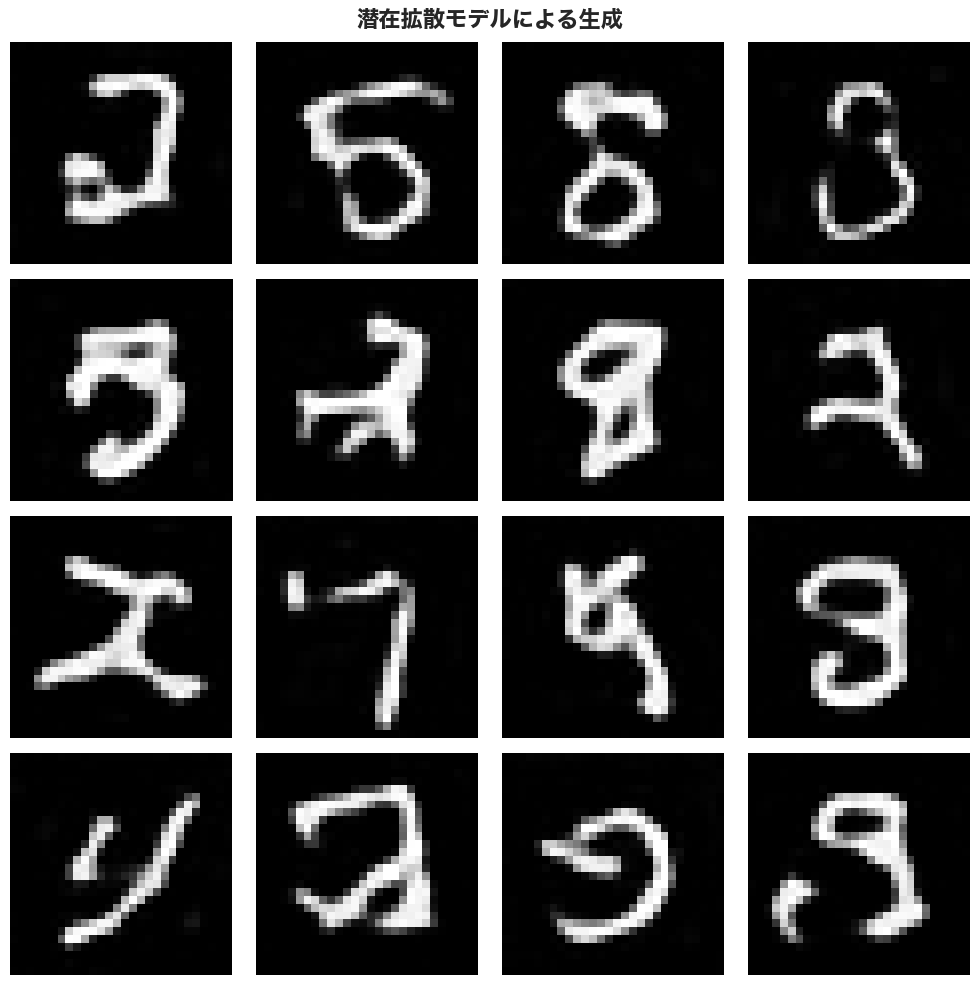

In [10]:
# ============================================================
# サンプル生成
# ============================================================

latent_unet.eval()

print("サンプル生成中...")
with torch.no_grad():
    samples, latents = ldm.sample(16, latent_shape)

# 結果を表示
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = samples[i].squeeze().cpu().numpy()
    img = np.clip(img * 0.5 + 0.5, 0, 1)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle('潜在拡散モデルによる生成', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

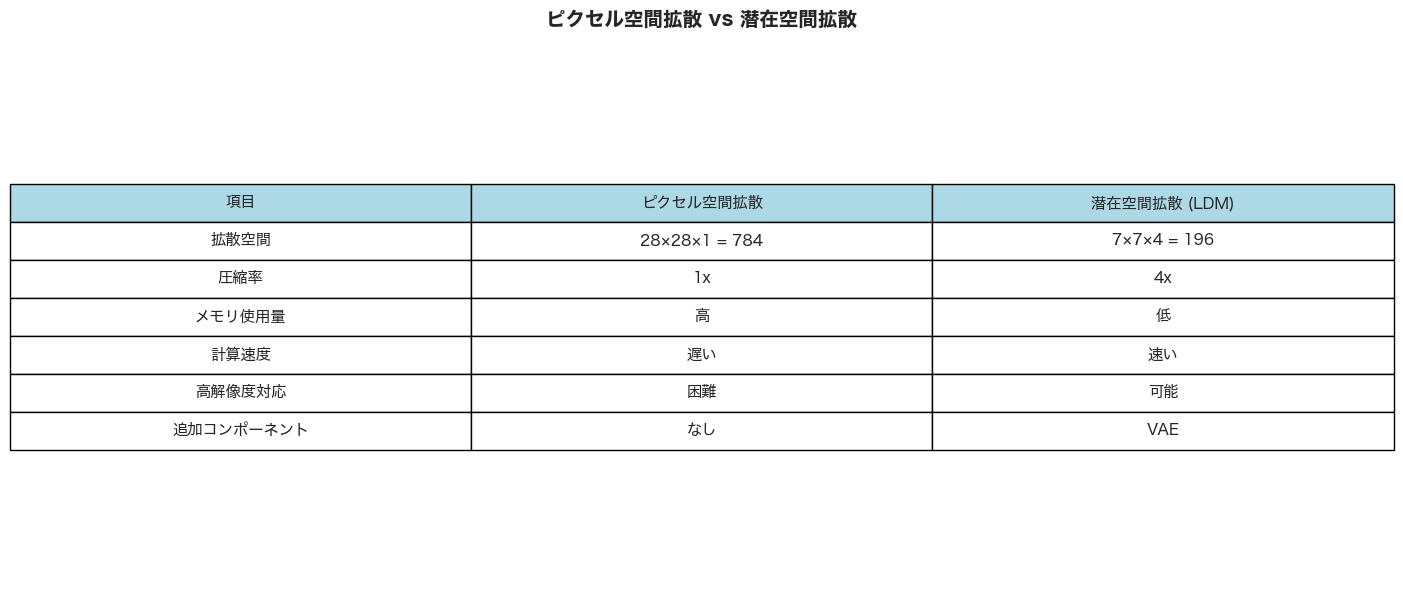

In [11]:
# ============================================================
# ピクセル空間 vs 潜在空間の比較
# ============================================================

fig, ax = plt.subplots(figsize=(14, 6))

# 比較表
comparison_data = [
    ['項目', 'ピクセル空間拡散', '潜在空間拡散 (LDM)'],
    ['拡散空間', '28×28×1 = 784', '7×7×4 = 196'],
    ['圧縮率', '1x', '4x'],
    ['メモリ使用量', '高', '低'],
    ['計算速度', '遅い', '速い'],
    ['高解像度対応', '困難', '可能'],
    ['追加コンポーネント', 'なし', 'VAE'],
]

table = ax.table(
    cellText=comparison_data[1:],
    colLabels=comparison_data[0],
    loc='center',
    cellLoc='center',
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# ヘッダーの色
for i in range(3):
    table[(0, i)].set_facecolor('lightblue')

ax.axis('off')
ax.set_title('ピクセル空間拡散 vs 潜在空間拡散', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 このノートブックで学んだこと

**潜在拡散モデル（LDM）**
- ✓ VAEによる画像圧縮
- ✓ 潜在空間での拡散
- ✓ 効率的な高解像度生成

**アーキテクチャ**
- ✓ VAE（エンコーダ + デコーダ）
- ✓ 潜在空間用U-Net
- ✓ 2段階訓練（VAE → 拡散）

### 📊 LDMの利点

| 特性 | 効果 |
|------|------|
| 次元削減 | 計算コスト大幅削減 |
| 意味的潜在空間 | より良い生成品質 |
| モジュール性 | VAEと拡散を別々に訓練可能 |
| スケーラビリティ | 高解像度画像に対応 |

### 📊 Stable Diffusionとの関係

Stable Diffusion = LDM + CLIP（テキスト条件付け）

- VAE: 画像 ↔ 潜在空間
- U-Net: 潜在空間での拡散
- CLIP: テキストエンコーダ

---

## 🎓 自己評価クイズ

### Q1: LDMがピクセル空間拡散より効率的な理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- VAEで画像を低次元の潜在空間に圧縮
- 例: 512×512×3 → 64×64×4（約48倍圧縮）
- 拡散プロセスの計算量が大幅に削減
- メモリ使用量も削減

</details>

---

### Q2: なぜVAEを先に訓練するのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- VAEは画像を意味のある潜在空間にマッピング
- 拡散モデルはこの潜在空間で動作
- VAEが不十分だと、拡散で良い画像を生成できない
- モジュール性：VAEを固定して拡散のみ訓練可能

</details>

---

### Q3: Stable DiffusionとLDMの違いは？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- Stable Diffusion = LDM + テキスト条件付け
- CLIPテキストエンコーダを使用
- Cross-Attentionでテキストを注入
- 大規模データセットで訓練

</details>

---

### ✅ 学習チェックリスト

- [ ] LDMの仕組みを説明できる
- [ ] VAEの役割を理解している
- [ ] 潜在空間での拡散を実装できる
- [ ] Stable Diffusionとの関係を説明できる

---

**次のステップ**: Notebook 44で、**テキスト条件付けとCLIP**を学びます！

In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class TimeConditionedBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.emb_proj = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, out_ch))
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    
    def forward(self, x, emb):
        h = self.act(self.norm1(self.conv1(x)))
        h = h + self.emb_proj(emb)[:, :, None, None]
        h = self.act(self.norm2(self.conv2(h)))
        return h + self.skip(x)


class LatentUNet(nn.Module):
    """潜在空間用のU-Net（任意のサイズに対応）"""
    
    def __init__(self, latent_channels=4, time_dim=128, base_ch=64):
        super().__init__()
        
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )
        
        self.init_conv = nn.Conv2d(latent_channels, base_ch, 3, padding=1)
        
        # エンコーダ
        self.down1 = TimeConditionedBlock(base_ch, base_ch * 2, time_dim)
        self.down2 = TimeConditionedBlock(base_ch * 2, base_ch * 4, time_dim)
        self.pool1 = nn.Conv2d(base_ch * 2, base_ch * 2, 3, stride=2, padding=1)
        
        # ボトルネック
        self.mid = TimeConditionedBlock(base_ch * 4, base_ch * 4, time_dim)
        
        # デコーダ
        self.up_conv1 = TimeConditionedBlock(base_ch * 4 + base_ch * 2, base_ch * 2, time_dim)
        self.up_conv2 = TimeConditionedBlock(base_ch * 2 + base_ch, base_ch, time_dim)
        
        self.final = nn.Conv2d(base_ch, latent_channels, 3, padding=1)
    
    def forward(self, z, t):
        t_emb = self.time_embed(t.float())
        
        h = self.init_conv(z)
        s1 = h  # skip (H, W)
        
        h = self.down1(h, t_emb)
        s2 = h  # skip (H, W)
        h = self.pool1(h)  # (H//2, W//2)
        
        h = self.down2(h, t_emb)
        h = self.mid(h, t_emb)
        
        # アップサンプリング: s2のサイズに合わせる
        h = F.interpolate(h, size=s2.shape[2:], mode='nearest')
        h = torch.cat([h, s2], dim=1)
        h = self.up_conv1(h, t_emb)
        
        # s1のサイズに合わせる（必要な場合）
        if h.shape[2:] != s1.shape[2:]:
            h = F.interpolate(h, size=s1.shape[2:], mode='nearest')
        h = torch.cat([h, s1], dim=1)
        h = self.up_conv2(h, t_emb)
        
        return self.final(h)

# テスト
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
latent_unet = LatentUNet(latent_channels=4).to(device)
z = torch.randn(2, 4, 7, 7, device=device)  # 28/4 = 7
t = torch.randint(0, 1000, (2,), device=device)
out = latent_unet(z, t)

print(f"潜在入力: {z.shape}")
print(f"潜在出力: {out.shape}")
print(f"パラメータ数: {sum(p.numel() for p in latent_unet.parameters()):,}")
print("\n✅ LatentUNet 正常動作!")


潜在入力: torch.Size([2, 4, 7, 7])
潜在出力: torch.Size([2, 4, 7, 7])
パラメータ数: 3,522,116

✅ LatentUNet 正常動作!
